<a href="https://colab.research.google.com/github/GaoangLiu/ipynb/blob/master/CNN_Quora_Insincere_Questions_Classification_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Quora insincere quetions classificaiton - Kaggle](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

## Problem Description 
 
In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

* Has a non-neutral tone
  * Has an exaggerated tone to underscore a point about a group of people
  * Is rhetorical and meant to imply a statement about a group of people
* Is disparaging or inflammatory
  * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
  * Makes disparaging attacks/insults against a specific person or group of people
  * Based on an outlandish premise about a group of people
  * Disparages against a characteristic that is not fixable and not measurable

* Isn't grounded in reality
  * Based on false information, or contains absurd assumptions
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.


In [0]:
# Get data from personal server
! wget -O quora.zip ali.140714.xyz:8000/quora.zip 
! unzip quora.zip 
! ls 

## Explore
Now let's play with the data !

In [0]:
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
logging.basicConfig(format='[%(asctime)s %(levelname)-8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS

from keras.datasets import imdb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.target.value_counts()
train.question_text.str.len().describe()

# for i in range(1, 100):
#   text_len = i * 10
#   print(f"Textlen upbound {text_len}")
#   vc = train[(train.question_text.str.len() <= text_len) & (train.question_text.str.len() >= text_len - 10)].target.value_counts()
#   print(f"Sincere {vc.get(0, 0)}, insincere {vc.get(1, 0)}, insincere ratio {vc.get(1, 0) / (vc.get(0, 0) + vc.get(1, 0.001))}")

test

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [0]:
sub = pd.read_csv('sample_submission.csv')
sub

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


## Findings
* The target value counts: `sincere 1225312, insincere 80810, ration 15:1`. Thus insincere is relatively rare in the questions 
* There are no empty questions, which is understandable, you're not asking a question until you say something. 
* `question_text`, 
  * mean length 70
  * std 30
  * min length 1 
  * max length 1017
* When the length of question text is above 10 and below 320, **the longer the length, the less sincere the question is**; for questions with length less than 10, 64.8% are insincere. 

Try CNN first. 

In [159]:
class DeepLearning():
  """ A template for running CNN models"""
  def __init__(self, max_features=100000, max_sentence_len=200, embedding_dim=100):
    self.max_features = max_features
    self.max_sentence_len = max_sentence_len
    self.embedding_dim = embedding_dim # For using embedded vector
    self.filepath="weights_base.best.hdf5" # saving the best model weights 

  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ A task-dependent method that will load data and do simple preprocessing,
      @return: train_data, test_data, train_labels, test_labels
      Load data and  """
      train = pd.read_csv(train_file, engine='python',\
          encoding='utf-8', error_bad_lines=False)
      test = pd.read_csv(test_file, engine='python', \
          encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
      return train, test

  def exploring_data(self, train):
      '''Find patterns, informations'''
      pass 

  def tokenize_text(self, text_train, text_test):
      '''@para: max_features, the most commenly used words in data set
      @input are vector of text
      '''
      tokenizer = Tokenizer(num_words=self.max_features)
      text = pd.concat([text_train, text_test])
      tokenizer.fit_on_texts(text)

      sequence_train = tokenizer.texts_to_sequences(text_train)
      tokenized_train = pad_sequences(sequence_train, maxlen=self.max_sentence_len)
      logging.info('Train text tokeninzed')

      sequence_test = tokenizer.texts_to_sequences(text_test)
      tokenized_test = pad_sequences(sequence_test, maxlen=self.max_sentence_len)
      logging.info('Test text tokeninzed')
      return tokenized_train, tokenized_test, tokenizer
      

  def embed_glove_vector(self, word_index, model='glove-wiki-gigaword-100'):
      glove = api.load(model) # default: wikipedia 6B tokens, uncased
      zeros = [0] * self.embedding_dim
      matrix = np.zeros((self.max_features, self.embedding_dim))
      
      for word, i in word_index.items(): 
          if i >= self.max_features or word not in glove: continue # matrix[0] is zeros, that's also why >= is here
          matrix[i] = glove[word]

      logging.info('Glove embedding vector created')
      return matrix


  def tfidf_vectorized(self, text_train, text_test):
      """ Tokenize text with TfidfVectorizer()
          Parameters such as ngram_range, max_features requires fine-tuning 
          @input: text Series, not DataFrame
      """
      tv = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', \
                          analyzer='word', token_pattern=r'\w{1,}',  stop_words='english', \
                          ngram_range=(1, 1), max_features=self.max_features)
      # features_train = tv.fit_transform(train.comment_text)
      # return features_train, 0
      return (tv.fit_transform(text) for text in (text_train, test_train))


  def build_model(self, embedding_matrix=np.zeros(0)):
      dropout = 0.5
      model = Sequential()
      model.add(Embedding(self.max_features, self.embedding_dim, input_length=self.max_sentence_len))
      model.add(Flatten())

      model.add(Dense(64, activation='relu'))
      model.add(Dropout(dropout))
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(1, activation='sigmoid'))

      if embedding_matrix.size > 0:
          model.layers[0].set_weights([embedding_matrix])
          model.layers[0].trainable = False
      logging.info(f'Model created')
      return model

  def run(self, model, x_train, y_train):
      checkpoint = ModelCheckpoint(self.filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

      model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
      X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=23)
      history = model.fit(X_tra, y_tra, epochs=3, batch_size=128, validation_data=(X_val, y_val), \
                          callbacks=[checkpoint, early], verbose=1)
      return model, history

  def display_history(self, history):
      acc = history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
    
  def predict(self, y_test, labels, sub_file="sample_submission.csv"):
      res = pd.read_csv(sub_file)
      res[labels] = y_test
      res.to_csv('submission.csv', index=False)
      logging.info(f"Predictions were written to submission.csv")

  def describe_model(self, **dm):
    for k, v in dm.items():
      print(f"{k}: {v}")


def save_predict(preds=[]):
  train['text_len'] = 10 + 10 * ((train.question_text.str.len() - 1) // 10)
  vc = train.groupby('text_len').target.value_counts()

  test['preds'] = preds
  test['text_len'] = 10 + 10 * ((test.question_text.str.len() - 1) // 10)
  max_preds = test.groupby('text_len').preds.max()
  min_preds = test.groupby('text_len').preds.min()

  def classify_pred(row): # to either 0 or 1
    tlen = row.text_len
    vmin, vmax = min_preds[tlen], max_preds[tlen]
    c0, c1 = vc.get((tlen, 0), 0.01), vc.get((tlen, 1), 0.01)
    r = c0 / (c0 + c1)
    return 1 if (row['preds'] - vmin) / (vmax - vmin) >= r else 0
  
  res = pd.read_csv('sample_submission.csv')
  res['prediction'] = test.apply(classify_pred, axis=1)
  res.to_csv('submission.csv', index=False)
  logging.info('Predictions were made through external method.')

  return res

def save_predict_v2(y_preds):
  bad, good = 80810, 1225312
  preds = sorted([e[0] for e in y_preds])
  idx_delta = int(len(preds) * (good / (good + bad)))
  delta = preds[idx_delta]

  res = pd.read_csv('sample_submission.csv')
  res['prediction'] = [1 if p >= delta else 0 for p in y_preds]
  res.to_csv('submission.csv', index=False)
  logging.info('Predictions were made through external method v2.')

  return res
  

# y_pred
time_start = timeit.default_timer()
dl = DeepLearning(max_features=200000, max_sentence_len=350, embedding_dim=300)
train, test = dl.load_data()
columns = ['target']
labels = train[columns].values

X_train, X_test, tokenizer = dl.tokenize_text(train["question_text"].fillna("_na_"), test["question_text"].fillna("_na_"))
# embedding_matrix = dl.embed_glove_vector(tokenizer.word_index, 'word2vec-google-news-300')

model = dl.build_model()
model, history = dl.run(model, X_train[:10000], labels[:10000])
model.load_weights(dl.filepath)
y_preds = model.predict(X_test, batch_size=1024, verbose=1)
final_preds = save_predict_v2(y_preds)

time_stop = timeit.default_timer()
print(f'Program run for {time_stop - time_start} seconds')


[05-07 08:36:40 INFO    ] Model created
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 3s 338us/step - loss: 0.3480 - acc: 0.9020 - val_loss: 0.2621 - val_acc: 0.9300

Epoch 00001: val_acc improved from -inf to 0.93000, saving model to weights_base.best.hdf5
Epoch 2/3
9000/9000 [==============================] - 3s 323us/step - loss: 0.2135 - acc: 0.9359 - val_loss: 0.1978 - val_acc: 0.9300

Epoch 00002: val_acc did not improve from 0.93000
Epoch 3/3
9000/9000 [==============================] - 3s 319us/step - loss: 0.1542 - acc: 0.9390 - val_loss: 0.2084 - val_acc: 0.9300

Epoch 00003: val_acc did not improve from 0.93000
375806/375806 [==============================] - 3s 9us/step


[05-07 08:36:56 INFO    ] Predictions were made through external method v2.


Program run for 16.149937967002188 seconds


In [160]:
sub = pd.read_csv('submission.csv')
bad, good = 80810, 1225312
# max_prob = max(sub.prediction)
# print(max_prob)
sub.prediction.value_counts()

0    352554
1     23252
Name: prediction, dtype: int64

0.6320300698280334


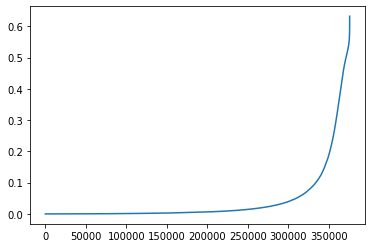

In [0]:
# ! mv submission.csv quora.csv
# ! curl -X PUT --upload-file quora.csv ali.140714.xyz:8000
# ! head submission.csv
